In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/AIES/NN Project/Phase2/OCT2017_dataset.zip' -d '/content' &> /dev/null

In [13]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
from tensorflow import keras
from keras import applications, optimizers
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Input, Dense, Flatten, Dropout, Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [7]:
DATA_DIR = '/content/OCT2017'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [11]:
IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 64

In [12]:
datagen = ImageDataGenerator(
    rescale= 1./255, 
)

train_generator = datagen.flow_from_directory(  
    TRAIN_DIR,  
    target_size= (IMG_WIDTH, IMG_HEIGHT), 
    color_mode= 'rgb',
    batch_size= BATCH_SIZE,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size= (IMG_WIDTH, IMG_HEIGHT),
    color_mode= 'rgb',
    batch_size= BATCH_SIZE,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = datagen.flow_from_directory(  
    TEST_DIR,  
    target_size= (IMG_WIDTH, IMG_HEIGHT), 
    color_mode= 'rgb',
    batch_size= BATCH_SIZE,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [18]:
print(train_generator.class_indices)
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [19]:
def create_model(in_shape,pool_size,kernal_size):
    inputs=Input(shape=in_shape)
    x=Convolution2D(filters=32,kernel_size=kernal_size,activation='relu')(inputs)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Convolution2D(filters=64,kernel_size=kernal_size,activation='relu')(x)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Convolution2D(filters=128,kernel_size=kernal_size,activation='relu')(x)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Convolution2D(filters=128,kernel_size=kernal_size,activation='relu')(x)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Flatten()(x)
    x=Dense(num_classes,activation='softmax')(x)
    return x,inputs

out,ins=create_model(in_shape=(IMG_WIDTH,IMG_HEIGHT,3),pool_size=(2,2),kernal_size=(3,3))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                         

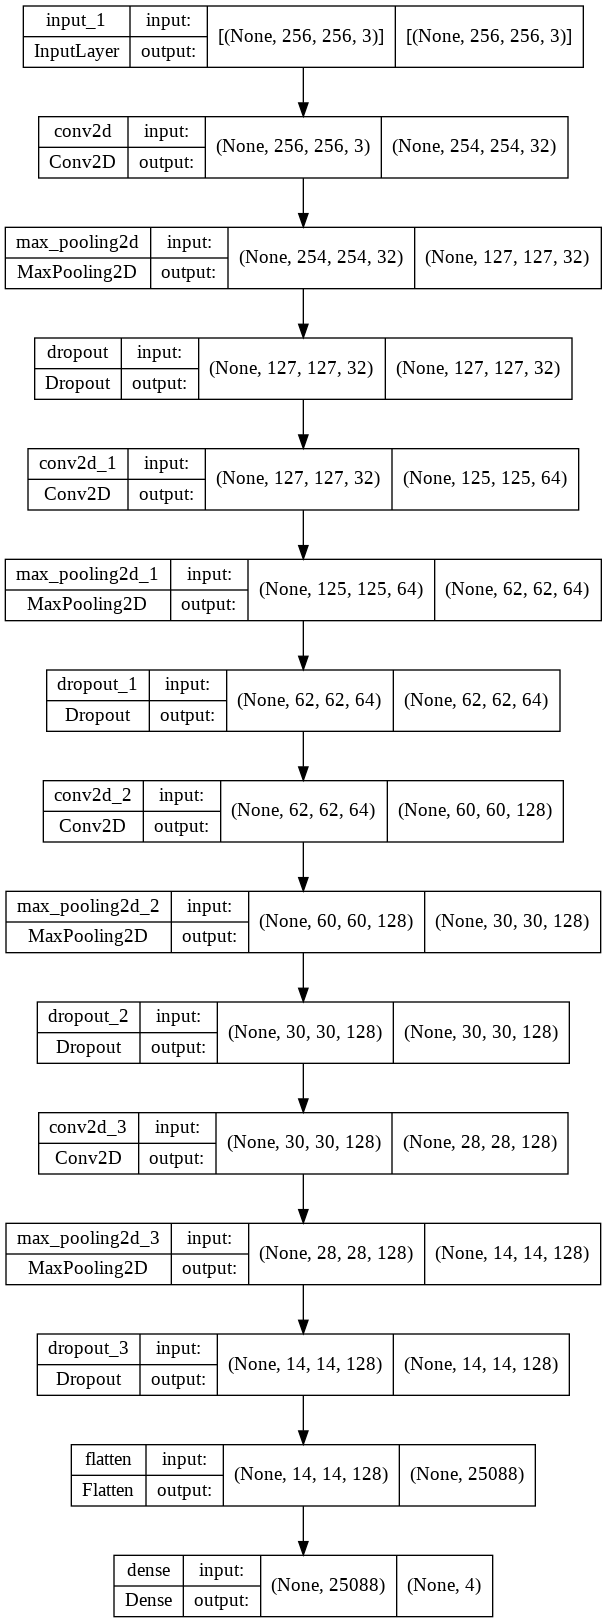

In [17]:
model=Model(inputs=ins, outputs=out)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

plot_model(model, show_shapes=True)

In [20]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq='epoch'
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [21]:
history = model.fit(
    train_generator, 
    epochs = 30,
    batch_size = BATCH_SIZE,
    validation_data = test_generator, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30
1305/1305 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.7326
Epoch 1: val_loss improved from inf to 0.53219, saving model to baseline_model.h5
1305/1305 [==============================] - 496s 370ms/step - loss: 0.7040 - accuracy: 0.7326 - val_loss: 0.5322 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 2/30
1305/1305 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8632
Epoch 2: val_loss improved from 0.53219 to 0.17152, saving model to baseline_model.h5
1305/1305 [==============================] - 447s 342ms/step - loss: 0.3890 - accuracy: 0.8632 - val_loss: 0.1715 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 3/30
1305/1305 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.9055
Epoch 3: val_loss improved from 0.17152 to 0.07004, saving model to baseline_model.h5
1305/1305 [==============================] - 422s 323ms/step - loss: 0.2749 - accuracy: 0.9055 - val_loss: 0.0700 - val_accuracy: 0.9793 - lr: 0.0010
Ep

Image is in NORMAL class
predicted class is: NORMAL


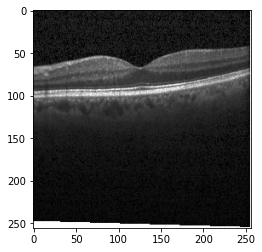

In [35]:
#VISUAL ANALYSIS 
from keras.preprocessing import image    
im1_path="/content/OCT2017/val/NORMAL/NORMAL-5171640-1.jpeg"
test_image=image.load_img(im1_path,target_size=(256,256))

print('Image is in NORMAL class')
plt.imshow(test_image)
# now to convert to 3 dimensional from 2d
test_image=image.img_to_array(test_image)
test_image= np.expand_dims(test_image,axis=0)

inv_map = {v: k for k, v in train_generator.class_indices.items()}
result=np.argmax(model.predict(test_image))
print('predicted class is:', inv_map[result])

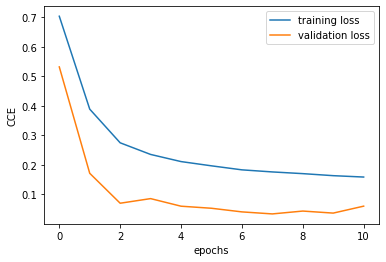

In [37]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')
plt.show()

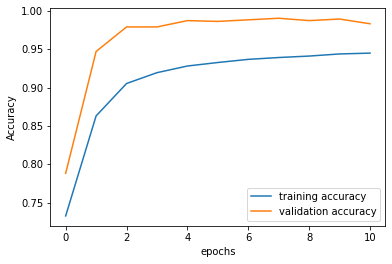

In [38]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy)
plt.plot(val_accuracy)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

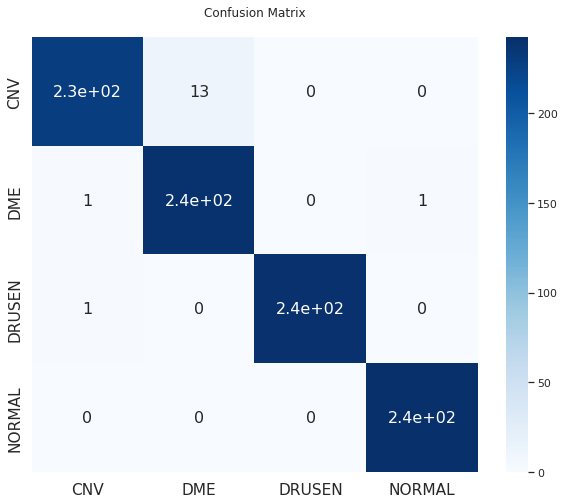

Classification Report

              precision    recall  f1-score   support

         CNV       0.99      0.95      0.97       242
         DME       0.95      0.99      0.97       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



In [50]:
Y_pred = model.predict(test_generator, batch_size= BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))